In [245]:
import torch
import torch.nn as nn
seed = 1
torch.manual_seed(seed)
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

In [246]:
import io
import os
import unicodedata
import string
import glob
from collections import OrderedDict

In [247]:
ALL_LETTERS = string.ascii_lowercase + " .,;'" + "<PAD>"
N_LETTERS = len(ALL_LETTERS)

In [248]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c.lower() in ALL_LETTERS
    )

In [249]:
unicode_to_ascii('Séverin')

'Severin'

In [250]:
def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().lower().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories

In [251]:
category_lines, all_categories = load_data()

In [252]:
all_categories

['French',
 'Dutch',
 'Chinese',
 'Greek',
 'Arabic',
 'Polish',
 'Portuguese',
 'Russian',
 'Irish',
 'Korean',
 'Spanish',
 'Czech',
 'Italian',
 'Vietnamese',
 'English',
 'Japanese',
 'Scottish',
 'German']

In [253]:
category_lines['French'][:5]

['abel', 'abraham', 'adam', 'albert', 'allard']

In [254]:
name_lengths = {}
for category, lines in category_lines.items():
    for line in lines:
        length = len(line)
        if length not in name_lengths:
            name_lengths[length] = 1
        else:
            name_lengths[length] += 1

<BarContainer object of 18 artists>

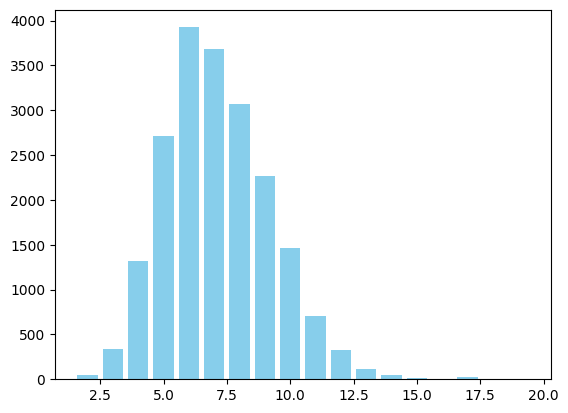

In [255]:
lengths = list(name_lengths.keys())
counts = list(name_lengths.values())

# Tạo biểu đồ
plt.bar(lengths, counts, color='skyblue')

In [256]:
sorted_lengths = OrderedDict(sorted(name_lengths.items()))
total_names = sum(sorted_lengths.values())
target_percentile = total_names * 0.9
cumulative_count = 0
for length, count in sorted_lengths.items():
    cumulative_count += count
    if cumulative_count >= target_percentile:
        percentile_90 = length
        break
print("90th percentile:", percentile_90)

90th percentile: 10


In [257]:
max_seq_length = percentile_90

In [258]:
def char2idx(char):
    return ALL_LETTERS.find(char)

In [259]:
def country2idx(country):
    return all_categories.index(country)

In [260]:
def name_to_tensor(name):
    splited_name = [c for c in name]
    if len(splited_name) < max_seq_length:
        splited_name += ['<PAD>'] * (max_seq_length - len(splited_name))
    elif len(splited_name) > max_seq_length:
        splited_name = splited_name[:max_seq_length]
    index_splited_name = [char2idx(c) for c in splited_name]
    return torch.tensor(index_splited_name)

In [261]:
class NameDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        label = country2idx(self.y[index])
        name = name_to_tensor(self.X[index])
        return name, label

In [262]:
category_lines.items()

dict_items([('French', ['abel', 'abraham', 'adam', 'albert', 'allard', 'archambault', 'armistead', 'arthur', 'augustin', 'babineaux', 'baudin', 'beauchene', 'beaulieu', 'beaumont', 'belanger', 'bellamy', 'bellerose', 'belrose', 'berger', 'beringer', 'bernard', 'bertrand', 'bisset', 'bissette', 'blaise', 'blanc', 'blanchet', 'blanchett', 'bonfils', 'bonheur', 'bonhomme', 'bonnaire', 'bonnay', 'bonner', 'bonnet', 'borde', 'bordelon', 'bouchard', 'boucher', 'brisbois', 'brodeur', 'bureau', 'caron', 'cavey', 'chaput', 'charbonneau', 'charpentier', 'charron', 'chastain', 'chevalier', 'chevrolet', 'cloutier', 'colbert', 'comtois', 'cornett', 'cote', 'coupe', 'courtemanche', 'cousineau', 'couture', 'daniau', "d'aramitz", 'daviau', 'david', 'deforest', 'degarmo', 'delacroix', 'de la fontaine', 'deniau', 'deniaud', 'deniel', 'denis', 'de sauveterre', 'deschamps', 'descoteaux', 'desjardins', 'desrochers', 'desrosiers', 'dubois', 'duchamps', 'dufort', 'dufour', 'duguay', 'dupond', 'dupont', 'dura

In [263]:
X = []
y = []
for category, lines in category_lines.items():
    for line in lines:
        X.append(line)
    y.extend([category]*len(lines))

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [265]:
train_dataset = NameDataset(X_train,y_train)
test_dataset = NameDataset(X_test,y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [266]:
class NameClassifier(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 hidden_size, 
                 n_layers, 
                 n_classes, 
                 dropout_prob):
        super(NameClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim,hidden_size,n_layers,batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32,n_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:,-1,:]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [267]:
vocab_size = len(ALL_LETTERS)
n_classes = len(all_categories)
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [268]:
model = NameClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)

In [269]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc

In [270]:
def train(model,
          train_loader,
          val_loader,
          criterion,
          optimizer,
          device,
          epochs):
    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)
        
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print(f'EPOCH {epoch + 1}:\t\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal acc: {val_acc:.4f}')
    return train_losses, val_losses, val_accs

In [271]:
lr = 1e-4
epochs = 200
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [272]:
train_losses, val_losses, val_accs = train(model,
                                 train_loader,
                                 test_loader,
                                 criterion,
                                 optimizer,
                                 device,
                                 epochs)

EPOCH 1:		Train loss: 2.4610	Val loss: 1.9804	Val acc: 0.4710
EPOCH 2:		Train loss: 1.8239	Val loss: 1.6668	Val acc: 0.5029
EPOCH 3:		Train loss: 1.6144	Val loss: 1.5123	Val acc: 0.5517
EPOCH 4:		Train loss: 1.5201	Val loss: 1.4564	Val acc: 0.5639
EPOCH 5:		Train loss: 1.4812	Val loss: 1.4276	Val acc: 0.5701
EPOCH 6:		Train loss: 1.4501	Val loss: 1.4120	Val acc: 0.5753
EPOCH 7:		Train loss: 1.4212	Val loss: 1.3742	Val acc: 0.5863
EPOCH 8:		Train loss: 1.3863	Val loss: 1.3298	Val acc: 0.6035
EPOCH 9:		Train loss: 1.3271	Val loss: 1.2995	Val acc: 0.6379
EPOCH 10:		Train loss: 1.2662	Val loss: 1.2154	Val acc: 0.6528
EPOCH 11:		Train loss: 1.2266	Val loss: 1.1767	Val acc: 0.6710
EPOCH 12:		Train loss: 1.1886	Val loss: 1.1557	Val acc: 0.6700
EPOCH 13:		Train loss: 1.1562	Val loss: 1.1174	Val acc: 0.6834
EPOCH 14:		Train loss: 1.1346	Val loss: 1.1047	Val acc: 0.6904
EPOCH 15:		Train loss: 1.1113	Val loss: 1.0890	Val acc: 0.6894
EPOCH 16:		Train loss: 1.0914	Val loss: 1.0637	Val acc: 0.6986
E

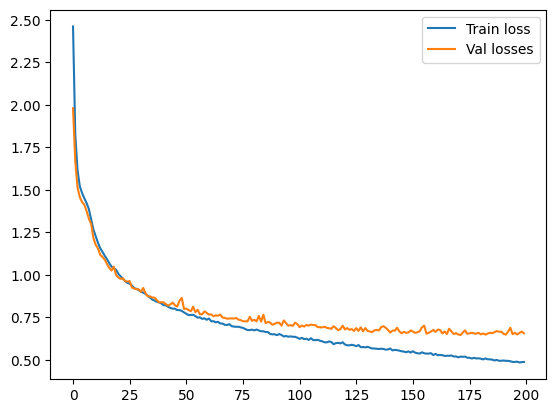

In [273]:
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val losses")
plt.legend()
plt.show()

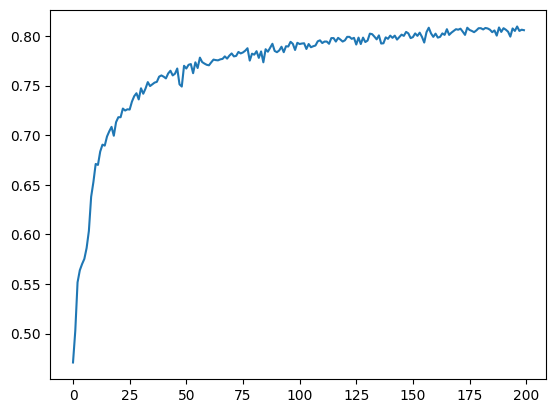

In [274]:
plt.plot(val_accs, label="Val acc")

In [275]:
def predict(x):
    print(f"\n> {x}")
    x = unicode_to_ascii(x.lower())
    x = name_to_tensor(x).to(device).unsqueeze(0)
    with torch.no_grad():
        output = model(x)
    return all_categories[torch.argmax(output,1).item()]

In [276]:
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    print(predict(sentence))


> Bao
Chinese

> Huyn
English

> hyun
Russian

> Park
English

> long
English

> long
English

> Almond
English

> Almond
English

> Ming
Chinese

> MOu
Chinese

> ming
Chinese

> ming
Chinese

> mot
Chinese

> thien
English

> trinh
English

> tirinh
English

> dsad
Arabic

> ggfas
English

> Quang
Chinese

> Quang
Chinese

> quach
English

> quyen
English

> quyen
English

> trinh
English

> thien
English

> hoang
Chinese

> hoang
Chinese
